# **Bayesian Neural Network**

# Get Data
Below gets the MNIST data and creates batches

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras as keras
from copy import deepcopy
from keras.models import load_model

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
x_train, x_val = tf.split(x_train, [50000, 10000], axis=0)
y_train, y_val = tf.split(y_train, [50000, 10000], axis=0)

train_size = x_train.shape[0]
batch_size = 128

x_train = x_train/126
x_val = x_val/126
x_test = x_test/126
y_train = tf.one_hot(y_train, 10)/1
y_val = tf.one_hot(y_val, 10)/1
y_test = tf.one_hot(y_test, 10)/1
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

path = 'drive/MyDrive/BNNresults/'


/Users/leo/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/leo/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/leo/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/leo/anaconda3/lib/python3.7/site-packages/tensorboard/compat

In [2]:
x_train.shape

TensorShape([50000, 28, 28])

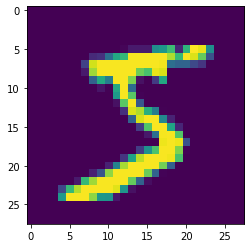

In [3]:
plt.imshow(x_train[0])

In [4]:
y_train[0]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)>

# Define Layer
A layer that imitates the Dense layer but introduces randomness

In [5]:
# Credits of this cell to: https://github.com/krasserm/bayesian-machine-learning

from keras import backend as K
from keras import activations, initializers
from keras.layers import Layer


class DenseVariational(Layer):
    def __init__(self,
                 units,
                 kl_weight,
                 activation=None,
                 prior_sigma_1=1.5,
                 prior_sigma_2=0.1,
                 prior_pi=0.5, 
                 **kwargs):
        self.units = units
        self.kl_weight = kl_weight
        self.activation = activations.get(activation)
        self.prior_sigma_1 = prior_sigma_1
        self.prior_sigma_2 = prior_sigma_2
        self.prior_pi_1 = prior_pi
        self.prior_pi_2 = 1.0 - prior_pi
        self.init_sigma = np.sqrt(self.prior_pi_1 * self.prior_sigma_1 ** 2 +
                                  self.prior_pi_2 * self.prior_sigma_2 ** 2)

        super().__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units

    def build(self, input_shape):
        self.kernel_mu = self.add_weight(name='kernel_mu',
                                         shape=(input_shape[1], self.units),
                                         initializer=initializers.TruncatedNormal(stddev=self.init_sigma),
                                         trainable=True)
        self.bias_mu = self.add_weight(name='bias_mu',
                                       shape=(self.units,),
                                       initializer=initializers.TruncatedNormal(stddev=self.init_sigma),
                                       trainable=True)
        self.kernel_rho = self.add_weight(name='kernel_rho',
                                          shape=(input_shape[1], self.units),
                                          initializer=initializers.Constant(-2),
                                          trainable=True)
        self.bias_rho = self.add_weight(name='bias_rho',
                                        shape=(self.units,),
                                        initializer=initializers.Constant(-2),
                                        trainable=True)
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        kernel_sigma = tf.math.softplus(self.kernel_rho)
        kernel = self.kernel_mu + kernel_sigma * tf.random.normal(self.kernel_mu.shape)

        bias_sigma = tf.math.softplus(self.bias_rho)
        bias = self.bias_mu + bias_sigma * tf.random.normal(self.bias_mu.shape)

        self.add_loss(self.kl_loss(kernel, self.kernel_mu, kernel_sigma) +
                      self.kl_loss(bias, self.bias_mu, bias_sigma))

        return self.activation(K.dot(inputs, kernel) + bias)

    def kl_loss(self, w, mu, sigma):
        variational_dist = tfp.distributions.Normal(mu, sigma)
        return self.kl_weight * K.sum(variational_dist.log_prob(w) - self.log_prior_prob(w))

    def log_prior_prob(self, w):
        comp_1_dist = tfp.distributions.Normal(0.0, self.prior_sigma_1)
        comp_2_dist = tfp.distributions.Normal(0.0, self.prior_sigma_2)
        return K.log(self.prior_pi_1 * comp_1_dist.prob(w) +
                     self.prior_pi_2 * comp_2_dist.prob(w))

# Build Model
Below builds a dense neural net with two hidden layers, each with 400 units. It outputs logits and does not include the softmax.

In [6]:
from keras.layers import Input, Flatten
from keras.models import Model

sample_size = 1
num_batches = train_size / batch_size
kl_weight = 1.0 / num_batches # Use this when loss is sum
# kl_weight = 1.0 / train_size / sample_size # Use this when loss is average (auto)


prior_params = {
    'prior_sigma_1': np.float32(np.exp(-1)), 
    'prior_sigma_2': np.float32(np.exp(-7)), 
    'prior_pi': 0.5 
}

x_in = Input(shape=(x_train.shape[1],x_train.shape[2]))
x = Flatten()(x_in)
x = DenseVariational(100, kl_weight, **prior_params, activation='relu')(x)
x = DenseVariational(100, kl_weight, **prior_params, activation='relu')(x)
x = DenseVariational(10, kl_weight, **prior_params, activation='linear')(x)

model = Model(x_in, x)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


# Run Model
It trains on sample_size (above cell) number of samples, and evaluates on eval_samples number of samples.

In [7]:
model(np.array([x_train[0]]))

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[-30.348038 ,  17.194899 ,  -3.8588586,  20.159048 , -20.722776 ,
        -12.019109 ,  -7.919631 ,  38.466488 , -20.176723 , -13.447058 ]],
      dtype=float32)>

In [8]:
from keras.optimizers import SGD
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
from tensorflow.nn import softmax

loss_fn = CategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.SUM)
optimizer = SGD(lr=1e-5, momentum=0.95)
train_metric = CategoricalAccuracy()
val_metric = CategoricalAccuracy()
test_metric = CategoricalAccuracy()

eval_samples = 10
sample_size = 1

def body_train_samples(loss_list, x_batch_train, y_batch_train, sample_size, i):
    logits = model(x_batch_train)
    loss_value = loss_fn(y_batch_train, logits)
    loss_list = tf.concat([loss_list, [loss_value]], axis=0)
    i = i + 1
    return loss_list, x_batch_train, y_batch_train, sample_size, i

def cond_train_samples(loss_list, x_batch_train, y_batch_train, sample_size, i):
    return i < sample_size

def body_eval_samples(pred_list, x, eval_samples, i):
    logits = model(x)
    pred_value = softmax(logits)
    pred_list = tf.concat([pred_list, [pred_value]], axis=0)
    i = i + 1
    return pred_list, x, eval_samples, i

def cond_eval_samples(pred_list, x, eval_samples, i):
    return i < eval_samples

In [ ]:
'''
Training begins
'''

epochs = 800
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        
        kl_reweight = 1 / kl_weight * (2**(num_batches-step-1)) / (2**num_batches - 1)
        kl_reweight = 1

        with tf.GradientTape() as tape:
            loss_list = tf.constant(tf.zeros(1))
            loss_list, x_, y_, s_, i_ = tf.while_loop(cond_train_samples,
                                                      body_train_samples, 
                                                      loop_vars=[loss_list,
                                                                 x_batch_train, y_batch_train, 
                                                                 sample_size, 0],
                                                      shape_invariants=[tf.TensorShape([None]),  
                                                                        x_batch_train.shape,
                                                                        y_batch_train.shape,
                                                                        tf.TensorShape([]),
                                                                        tf.TensorShape([])])
            loss_list = tf.gather(loss_list, list(range(1, sample_size+1)))
            loss_value = tf.reduce_mean(loss_list, axis=0)
            loss_value += sum(model.losses) * kl_reweight

        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if step % 200 == 0:
            print("Training loss (for one batch) at step %d: %.4f" % (step, float(loss_value)))

    pred_list = tf.constant(tf.zeros((1, x_train.shape[0], y_train.shape[1])))
    pred_list, x_, s_, i_ = tf.while_loop(cond_eval_samples,
                                          body_eval_samples, 
                                          loop_vars=[pred_list, x_train, 
                                                     eval_samples, 0],
                                          shape_invariants=[tf.TensorShape([None, x_train.shape[0], y_train.shape[1]]), 
                                                            x_train.shape,
                                                            tf.TensorShape([]),
                                                            tf.TensorShape([])])
    pred_list = tf.gather(pred_list, list(range(1, eval_samples+1)))
    pred_value = tf.reduce_mean(pred_list, axis=0)
    
    train_metric.update_state(y_train, pred_value)
    train_acc = train_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))
    train_metric.reset_states()

    val_pred_list = tf.constant(tf.zeros((1, x_val.shape[0], y_val.shape[1])))
    val_pred_list, x_, s_, i_ = tf.while_loop(cond_eval_samples,
                                              body_eval_samples, 
                                              loop_vars=[val_pred_list, x_val, 
                                                         eval_samples, 0],
                                              shape_invariants=[tf.TensorShape([None, x_val.shape[0], y_val.shape[1]]), 
                                                                x_val.shape,
                                                                tf.TensorShape([]),
                                                                tf.TensorShape([])])
    val_pred_list = tf.gather(val_pred_list, list(range(1, eval_samples+1)))
    val_pred_value = tf.reduce_mean(val_pred_list, axis=0)

    val_metric.update_state(y_val, val_pred_value)
    val_acc = val_metric.result()
    print("Validation acc over epoch: %.4f" % (float(val_acc),))
    val_metric.reset_states()

    if epoch % 20 == 0:
        model.save(path)

# Analyze Model

Test accuracy. Blundell, et al. (2015) reports 98.68% test accuracy for their best model.

In [ ]:
# model.save(path+'model_rho_2/')

In [ ]:
model = load_model(path+'model_rho_2/')
w = model.get_weights()
eval_samples = 100

In [ ]:
pred_list = tf.constant(tf.zeros((1, x_test.shape[0], y_test.shape[1])))
pred_list, x_, s_, i_ = tf.while_loop(cond_eval_samples,
                                      body_eval_samples, 
                                      loop_vars=[pred_list, x_test, 
                                                eval_samples, 0],
                                      shape_invariants=[tf.TensorShape([None, x_test.shape[0], y_test.shape[1]]), 
                                                        x_test.shape,
                                                        tf.TensorShape([]),
                                                        tf.TensorShape([])])
pred_list = tf.gather(pred_list, list(range(1, eval_samples+1)))
pred_value = tf.reduce_mean(pred_list, axis=0)

test_metric.update_state(y_test, pred_value)
test_acc = test_metric.result()
print("Test accuracy: %.4f" % (float(test_acc),))
test_metric.reset_states()

Test accuracy: 0.9818


Get signal-to-noise ratio, and reproduce Figure 4 of Blundell, et al. (2015). We also test model properties after weights are removed based on the signal-to-noise ratio.

In [ ]:
model.set_weights(w)

In [ ]:
'''
Weights pruning.
This section depends on the knowledge that, model weights follows this format:
for each layer:
    weight_mu
    bias_mu
    weight_rho
    bias_rho
'''

sn_ratio = []
for i in range(0, len(w), 4):
    sn_ratio.append(w[i]/tf.math.softplus(w[i+2]))
    sn_ratio.append(w[i+1]/tf.math.softplus(w[i+3]))

sorted_ratio = []
for i in range(len(sn_ratio)):
    sorted_ratio.append(np.argsort(np.reshape(abs(sn_ratio[i]), (-1,))))

remove_ratio = 0.75

new_weights = deepcopy(w)
for i in range(0, len(sorted_ratio), 2):
    remove_until_1 = min(int(len(sorted_ratio[i]) * remove_ratio), (len(sorted_ratio[i])-1))
    remove_until_2 = min(int(len(sorted_ratio[i+1]) * remove_ratio), (len(sorted_ratio[i+1])-1))
    for j in range(remove_until_1):
        rmv_idx = sorted_ratio[i][j]
        idx1 = int(rmv_idx / w[i*2].shape[1])
        idx2 = rmv_idx - idx1 * w[i*2].shape[1]
        new_weights[i*2][idx1, idx2] = 0.0
        new_weights[i*2+2][idx1, idx2] = -100.0
    for j in range(remove_until_2):
        idx = sorted_ratio[i+1][j]
        new_weights[i*2+1][idx] = 0.0
        new_weights[i*2+3][idx] = -100.0

In [ ]:
model_2 = load_model(path+'model_1200_1200_10_relu/')
w_2 = model_2.get_weights()

In [ ]:
'''
Baseline for weights pruning
'''

sn_ratio_2 = []
for i in range(0, len(w_2)):
    sn_ratio_2.append(w_2[i])

sorted_ratio_2 = []
for i in range(len(sn_ratio_2)):
    sorted_ratio_2.append(np.argsort(np.reshape(abs(sn_ratio_2[i]), (-1,))))

remove_ratio = 0.98

new_weights_2 = deepcopy(w_2)
for i in range(0, len(sorted_ratio_2), 2):
    remove_until_1 = min(int(len(sorted_ratio_2[i]) * remove_ratio), (len(sorted_ratio_2[i])-1))
    remove_until_2 = min(int(len(sorted_ratio_2[i+1]) * remove_ratio), (len(sorted_ratio_2[i+1])-1))
    for j in range(remove_until_1):
        rmv_idx = sorted_ratio_2[i][j]
        idx1 = int(rmv_idx / w_2[i].shape[1])
        idx2 = rmv_idx - idx1 * w_2[i].shape[1]
        new_weights_2[i][idx1, idx2] = 0.0
    for j in range(remove_until_2):
        idx = sorted_ratio_2[i+1][j]
        new_weights_2[i+1][idx] = 0.0

In [ ]:
model.set_weights(new_weights)

pred_list = tf.constant(tf.zeros((1, x_test.shape[0], y_test.shape[1])))
pred_list, x_, s_, i_ = tf.while_loop(cond_eval_samples,
                                      body_eval_samples, 
                                      loop_vars=[pred_list, x_test, 
                                                 eval_samples, 0],
                                      shape_invariants=[tf.TensorShape([None, x_test.shape[0], y_test.shape[1]]), 
                                                        x_test.shape,
                                                        tf.TensorShape([]),
                                                        tf.TensorShape([])])
pred_list = tf.gather(pred_list, list(range(1, eval_samples+1)))
pred_value = tf.reduce_mean(pred_list, axis=0)

test_metric.update_state(y_test, pred_value)
test_acc = test_metric.result()
print("Test accuracy: %.4f" % (float(test_acc),))
test_metric.reset_states()

Test accuracy: 0.9816


In [ ]:
model_2.set_weights(new_weights_2)
model_2.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 2.1039 - categorical_accuracy: 0.3820


[2.1039233207702637, 0.38199999928474426]

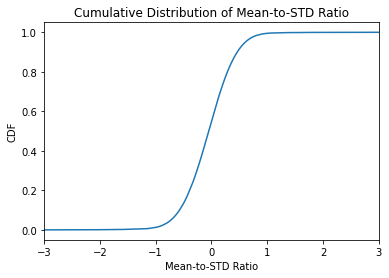

In [ ]:
ratio_list = []
for i in range(len(sn_ratio)):
    ratio_list.extend(np.reshape(sn_ratio[i], (-1,)))
ratio_list.sort()
plt.plot(ratio_list, np.array(list(range(len(ratio_list))))/len(ratio_list))
plt.xlim(-3,3)
plt.xlabel('Mean-to-STD Ratio')
plt.ylabel('CDF')
plt.title('Cumulative Distribution of Mean-to-STD Ratio')
plt.show()


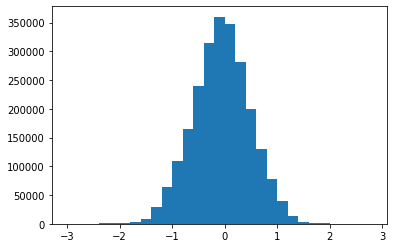

In [ ]:
plt.hist(ratio_list, bins=np.arange(-3, 3, 0.2))
plt.show()

In [ ]:
def weights_to_dict(w, save=True, name='weights.npy'):
    weights_dict = {}
    for i in range(0, len(w), 4):
        weights_dict['kernel_mu'+str(int((i+4)/4))] = w[i]
        weights_dict['bias_mu'+str(int((i+4)/4))] = w[i+1]
        weights_dict['kernel_rho'+str(int((i+4)/4))] = w[i+2]
        weights_dict['bias_rho'+str(int((i+4)/4))] = w[i+3]
    if save:
        np.save(path+name, weights_dict)
    return weights_dict